In [1]:
# Jalankan ini di cell pertama untuk menginstall library yang dibutuhkan
!pip install google-play-scraper Sastrawi pandas scikit-learn matplotlib seaborn

In [4]:
# ==========================================
# TAHAP 0: INSTALASI & IMPORT LIBRARY
# ==========================================
# Pastikan library ini sudah terinstall:
# !pip install google-play-scraper Sastrawi pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google_play_scraper import Sort, reviews
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ==========================================
# TAHAP 1: SCRAPING DATA (1 TAHUN TERAKHIR)
# ==========================================

target_app_id = 'superapps.polri.presisi.presisi'
cutoff_date = datetime.now() - timedelta(days=365) # Batas waktu 1 tahun lalu

print(f"Mulai mengambil ulasan sejak: {cutoff_date.date()}...")

scraped_data = []
continuation_token = None

while True:
    # Ambil data per batch (200 ulasan per request)
    result, continuation_token = reviews(
        target_app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=200,
        continuation_token=continuation_token
    )
    
    # Tambahkan ke list utama
    scraped_data.extend(result)
    
    # Ambil tanggal ulasan terakhir di batch ini
    last_review_date = result[-1]['at']
    
    print(f"  - Mengambil... Sampai tanggal: {last_review_date.date()}")
    
    # Cek kondisi berhenti:
    # 1. Jika tanggal terakhir sudah lebih tua dari cutoff (1 tahun lalu)
    # 2. Atau jika tidak ada lagi data (token habis)
    if last_review_date < cutoff_date or continuation_token is None:
        break

# Konversi ke DataFrame
df = pd.DataFrame(scraped_data)

# Filter final: Pastikan membuang sisa data di batch terakhir yang lewat tanggal
df = df[df['at'] >= cutoff_date]

print(f"\nSukses! Total ulasan 1 tahun terakhir: {len(df)}")
print(df[['at', 'content', 'score']].head())

Mulai mengambil ulasan sejak: 2025-02-10...
  - Mengambil... Sampai tanggal: 2026-02-05
  - Mengambil... Sampai tanggal: 2026-02-02
  - Mengambil... Sampai tanggal: 2026-01-29
  - Mengambil... Sampai tanggal: 2026-01-26
  - Mengambil... Sampai tanggal: 2026-01-22
  - Mengambil... Sampai tanggal: 2026-01-20
  - Mengambil... Sampai tanggal: 2026-01-18
  - Mengambil... Sampai tanggal: 2026-01-15
  - Mengambil... Sampai tanggal: 2026-01-13
  - Mengambil... Sampai tanggal: 2026-01-10
  - Mengambil... Sampai tanggal: 2026-01-08
  - Mengambil... Sampai tanggal: 2026-01-07
  - Mengambil... Sampai tanggal: 2026-01-05
  - Mengambil... Sampai tanggal: 2026-01-03
  - Mengambil... Sampai tanggal: 2025-12-30
  - Mengambil... Sampai tanggal: 2025-12-26
  - Mengambil... Sampai tanggal: 2025-12-23
  - Mengambil... Sampai tanggal: 2025-12-19
  - Mengambil... Sampai tanggal: 2025-12-17
  - Mengambil... Sampai tanggal: 2025-12-15
  - Mengambil... Sampai tanggal: 2025-12-12
  - Mengambil... Sampai tanggal:

In [8]:
# 1. Pelabelan (Labeling)
def pelabelan(score):
    if score >= 4:
        return 'Positif'
    elif score <= 2:
        return 'Negatif'
    else:
        return 'Netral'

df['sentimen'] = df['score'].apply(pelabelan)

# Hapus Netral agar fokus Positif vs Negatif
df_clean = df[df['sentimen'] != 'Netral'].copy()

# 2. Text Preprocessing
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Hapus angka & simbol
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi ganda
    
    # Opsional: Stemming (bisa dimatikan jika data > 5000 agar cepat)
    # text = stemmer.stem(text) 
    
    return text

print("\nSedang melakukan preprocessing teks...")
df_clean['text_processed'] = df_clean['content'].apply(cleaning_text)


Sedang melakukan preprocessing teks...


In [9]:
# ==========================================
# TAHAP 3: TF-IDF & SPLIT DATA
# ==========================================

X = df_clean['text_processed']
y = df_clean['sentimen']

# Split Data (80% Latih, 20% Uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vektorisasi TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [10]:
# ==========================================
# TAHAP 4: TRAINING MODEL SVM
# ==========================================

print("Sedang melatih model SVM...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# ==========================================
# TAHAP 5: EVALUASI & VISUALISASI
# ==========================================

y_pred = svm_model.predict(X_test_tfidf)

print("\n=== HASIL EVALUASI ===")
print(f"Akurasi: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Sedang melatih model SVM...

=== HASIL EVALUASI ===
Akurasi: 94.92%

Classification Report:
               precision    recall  f1-score   support

     Negatif       0.90      0.94      0.92      1828
     Positif       0.97      0.95      0.96      4212

    accuracy                           0.95      6040
   macro avg       0.94      0.95      0.94      6040
weighted avg       0.95      0.95      0.95      6040



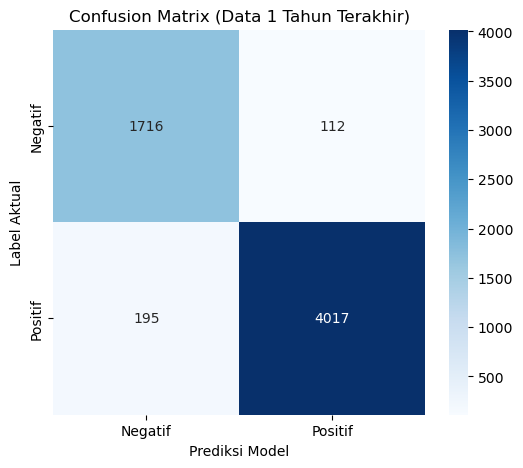

C:\Users\USER\AppData\Local\Temp\ipykernel_15164\132069695.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimen', data=df_clean, palette='viridis')


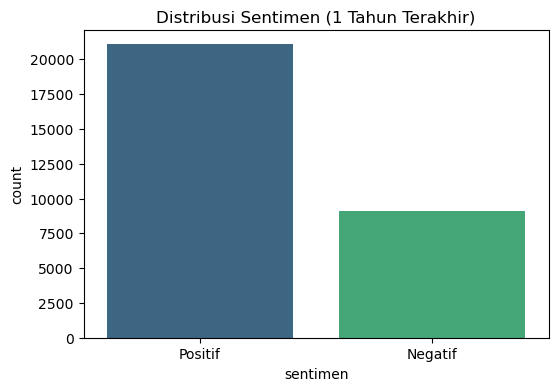

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Positif'], 
            yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Aktual')
plt.title('Confusion Matrix (Data 1 Tahun Terakhir)')
plt.show()

# Distribusi Sentimen
plt.figure(figsize=(6,4))
sns.countplot(x='sentimen', data=df_clean, palette='viridis')
plt.title('Distribusi Sentimen (1 Tahun Terakhir)')
plt.show()

In [12]:
# MELIHAT KATA KUNCI PALING BERPENGARUH (FEATURE IMPORTANCE)
# Karena kita pakai SVM Kernel Linear, kita bisa lihat koefisien kata

feature_names = vectorizer.get_feature_names_out()
coefs = svm_model.coef_.toarray()[0]

# Gabungkan kata dan bobotnya
word_importances = pd.DataFrame({'word': feature_names, 'coef': coefs})

# Kata paling NEGATIF (Penyebab sentimen negatif)
top_negative = word_importances.sort_values(by='coef').head(10)

# Kata paling POSITIF
top_positive = word_importances.sort_values(by='coef', ascending=False).head(10)

print("\n=== 10 KATA KUNCI PENYEBAB SENTIMEN NEGATIF ===")
print(top_negative)

print("\n=== 10 KATA KUNCI PENYEBAB SENTIMEN POSITIF ===")
print(top_positive)


=== 10 KATA KUNCI PENYEBAB SENTIMEN NEGATIF ===
              word      coef
1675   mempersulit -3.410486
454          buruk -3.144459
1362        kurang -2.984878
1519         malah -2.604767
2020         parah -2.544999
1771   menyusahkan -2.483195
779          error -2.396644
1398        lambat -2.390740
1718  mengecewakan -2.305521
674     dipersulit -2.266665

=== 10 KATA KUNCI PENYEBAB SENTIMEN POSITIF ===
               word      coef
481           cepat  3.101702
2487         semoga  3.080872
1824          mudah  2.883507
1244          keren  2.807708
62    alhamdulillah  2.430670
19             agak  2.075784
1488        lumayan  1.933723
1683     memudahkan  1.849165
1546         mantap  1.779335
1168     kedepannya  1.726434


In [15]:
# ==========================================
# CEK HASIL PREPROCESSING
# ==========================================

# 1. Atur agar kolom pandas menampilkan seluruh teks (tidak dipotong/titik-titik)
pd.set_option('display.max_colwidth', None)

# 2. Ambil sampel acak 10 data
# Kita pakai .sample() agar yang muncul acak, bukan cuma data teratas
cek_perbandingan = df_clean[['content', 'text_processed', 'sentimen']].sample(10)

# 3. Tampilkan
print("=== PERBANDINGAN TEXT ASLI VS TEXT PROCESSED ===")
display(cek_perbandingan) # Jika error 'display not defined', ganti jadi print(cek_perbandingan)

=== PERBANDINGAN TEXT ASLI VS TEXT PROCESSED ===


,content,text_processed,sentimen
24915,masyaallah pendaftaran lancar,masyaallah pendaftaran lancar,Positif
4155,mantap,mantap,Positif
621,akses cepat,akses cepat,Positif
14426,sangat membantu,sangat membantu,Negatif
24573,"pelayanannya mantar, cepat dan efesien Waktu",pelayanannya mantar cepat dan efesien waktu,Positif
12655,mempermudah keperluan masyarakat,mempermudah keperluan masyarakat,Positif
20316,baguss,baguss,Positif
21383,mantap,mantap,Positif
15708,"sangat membantu sekali ,dan memuaskan",sangat membantu sekali dan memuaskan,Positif
27333,sàngat baik,sngat baik,Positif


### IndoBERT

In [16]:
# ==========================================
# 1. INSTALASI LIBRARY KHUSUS TRANSFORMERS
# ==========================================
!pip install transformers torch scikit-learn accelerate -q

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [17]:
# ==========================================
# 2. PERSIAPAN DATASET
# ==========================================

# Kita gunakan data yang sama (df_clean)
# Mapping label: Negatif = 0, Positif = 1
label_map = {'Negatif': 0, 'Positif': 1}
df_clean['label'] = df_clean['sentimen'].map(label_map)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df_clean['content'].tolist(), 
    df_clean['label'].tolist(), 
    test_size=0.2, 
    random_state=42
)

# Load Tokenizer IndoBERT (Model Pre-trained buatan IndoBenchmark)
print("Sedang mendownload Tokenizer IndoBERT...")
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Fungsi Tokenisasi
def tokenize_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

# Tokenisasi Data Train & Test
train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Membuat Class Dataset untuk PyTorch
class PolriDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = PolriDataset(train_encodings, y_train)
test_dataset = PolriDataset(test_encodings, y_test)

Sedang mendownload Tokenizer IndoBERT...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

C:\Users\USER\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--indobenchmark--indobert-base-p1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [19]:
# ==========================================
# 3. KONFIGURASI MODEL & TRAINING
# ==========================================

# Load Model IndoBERT untuk Klasifikasi (2 Label: Positif/Negatif)
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', num_labels=2)

# Fungsi untuk menghitung metrik saat evaluasi
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

from transformers import TrainingArguments

# Pengaturan Training (Hyperparameters)
training_args = TrainingArguments(
    output_dir='./results',          # Folder output
    num_train_epochs=3,              # Jumlah epoch
    per_device_train_batch_size=16,  # Batch size training
    per_device_eval_batch_size=64,   # Batch size evaluasi
    warmup_steps=500,                # Pemanasan learning rate
    weight_decay=0.01,               # Regularization
    logging_dir='./logs',            # Folder logs
    logging_steps=50,
    
    # --- BAGIAN YANG DIPERBAIKI ---
    eval_strategy="epoch",           # DULU: evaluation_strategy, SEKARANG: eval_strategy
    save_strategy="epoch",           # Simpan model tiap akhir epoch
    # ------------------------------
    
    load_best_model_at_end=True      # Ambil model terbaik di akhir
)

# Inisialisasi Ulang Trainer dengan arguments baru
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Jalankan Training lagi
print("\nMulai Training IndoBERT... (Bisa memakan waktu 10-20 menit tergantung GPU)")
trainer.train()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: indobenchmark/indobert-base-p1
Key               | Status  | 
------------------+---------+-
classifier.weight | MISSING | 
classifier.bias   | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.



Mulai Training IndoBERT... (Bisa memakan waktu 10-20 menit tergantung GPU)


C:\Users\USER\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.210855,0.157927,0.947020,0.961585,0.972559,0.950855
2,0.126443,0.174447,0.952483,0.965492,0.978076,0.953229
3,0.133320,0.164253,0.953311,0.966219,0.975097,0.957502


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\USER\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\USER\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

TrainOutput(global_step=4530, training_loss=0.17416929219732222, metrics={'train_runtime': 17141.2361, 'train_samples_per_second': 4.228, 'train_steps_per_second': 0.264, 'total_flos': 4766782989957120.0, 'train_loss': 0.17416929219732222, 'epoch': 3.0})

In [21]:
print("\nMelakukan Evaluasi Akhir...")
eval_result = trainer.evaluate()

print("\n=== HASIL INDOBERT ===")
print(f"Accuracy : {eval_result['eval_accuracy']*100:.2f}%")
print(f"F1 Score : {eval_result['eval_f1']*100:.2f}%")
print(f"Precision: {eval_result['eval_precision']*100:.2f}%")
print(f"Recall   : {eval_result['eval_recall']*100:.2f}%")


Melakukan Evaluasi Akhir...


C:\Users\USER\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



=== HASIL INDOBERT ===
Accuracy : 94.72%
F1 Score : 96.17%
Precision: 97.26%
Recall   : 95.11%


### ANALISIS 

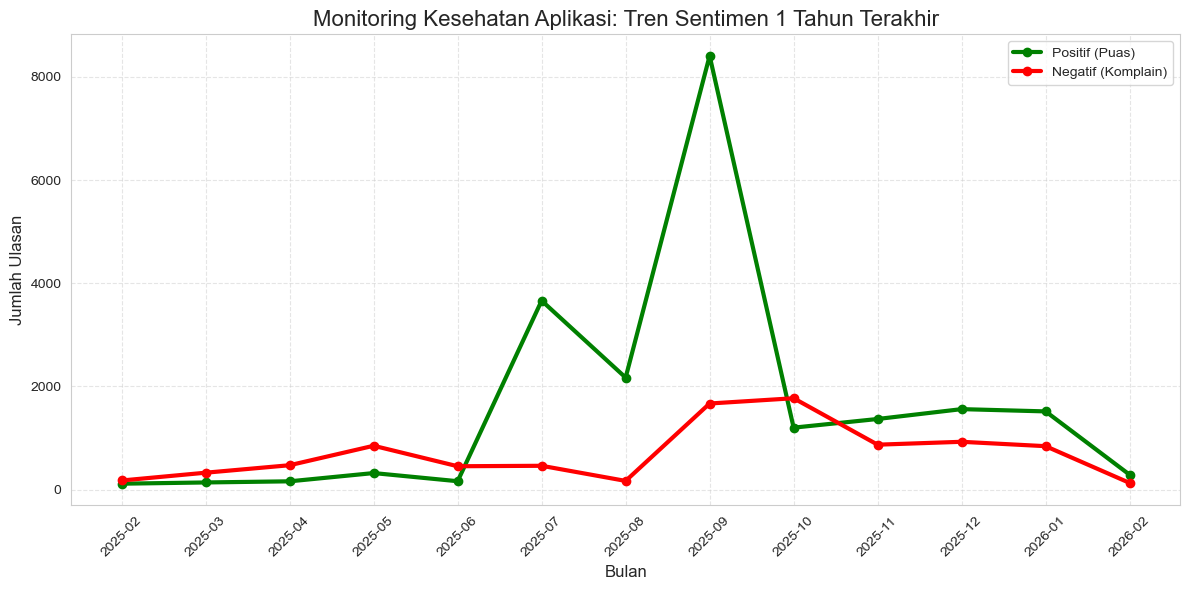

Total Data: 30196 ulasan


In [23]:
## Melihat apakah update aplikasi membuat pengguna senang atau marah dari waktu ke waktu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

# Konfigurasi Tampilan
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Pastikan format tanggal benar
df_clean['at'] = pd.to_datetime(df_clean['at'])
df_clean['bulan'] = df_clean['at'].dt.to_period('M')

# 2. Hitung Data Tren (Positif vs Negatif per Bulan)
trend = df_clean.groupby(['bulan', 'sentimen']).size().unstack(fill_value=0)

# 3. Plotting Grafik Garis
plt.figure(figsize=(12, 6))
plt.plot(trend.index.astype(str), trend['Positif'], marker='o', color='green', linewidth=3, label='Positif (Puas)')
plt.plot(trend.index.astype(str), trend['Negatif'], marker='o', color='red', linewidth=3, label='Negatif (Komplain)')

plt.title('Monitoring Kesehatan Aplikasi: Tren Sentimen 1 Tahun Terakhir', fontsize=16)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Total Data: {len(df_clean)} ulasan")

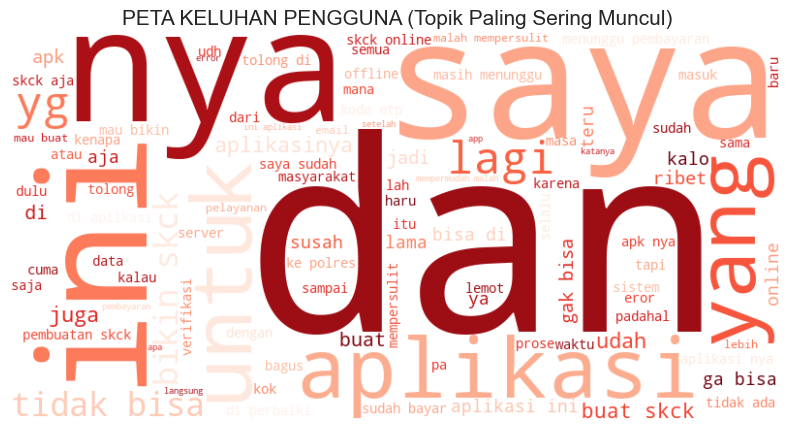


=== ⚠️ TOP 10 PENYEBAB KEKECEWAAN MASYARAKAT ===
1. Isu 'APLIKASI' 	: Muncul 3795 kali
2. Isu 'SKCK' 	: Muncul 2884 kali
3. Isu 'BISA' 	: Muncul 2614 kali
4. Isu 'TIDAK' 	: Muncul 2090 kali
5. Isu 'SAYA' 	: Muncul 1878 kali
6. Isu 'SUDAH' 	: Muncul 1717 kali
7. Isu 'MALAH' 	: Muncul 1651 kali
8. Isu 'BUAT' 	: Muncul 1528 kali
9. Isu 'TAPI' 	: Muncul 1446 kali
10. Isu 'BIKIN' 	: Muncul 1433 kali


In [25]:
### Menemukan kata kunci spesifik yang menjadi "biang kerok" keluhan pengguna)


# 1. Ambil teks khusus ulasan NEGATIF
text_negatif = " ".join(df_clean[df_clean['sentimen'] == 'Negatif']['text_processed'])

# 2. Buat WordCloud
# Gunakan colormap 'Reds' agar terlihat seperti "Warning"
wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=100).generate(text_negatif)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('PETA KELUHAN PENGGUNA (Topik Paling Sering Muncul)', fontsize=15)
plt.show()

# 3. Statistik Kata (Top 10 Penyebab Masalah)
from collections import Counter
words = [w for w in text_negatif.split() if len(w) > 3] # Abaikan kata pendek
common_words = Counter(words).most_common(10)

print("\n=== ⚠️ TOP 10 PENYEBAB KEKECEWAAN MASYARAKAT ===")
for i, (word, freq) in enumerate(common_words, 1):
    print(f"{i}. Isu '{word.upper()}' \t: Muncul {freq} kali")

C:\Users\USER\AppData\Local\Temp\ipykernel_15164\1652042843.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tingkat Kegagalan (%)', y='Layanan', data=df_audit, palette='magma')


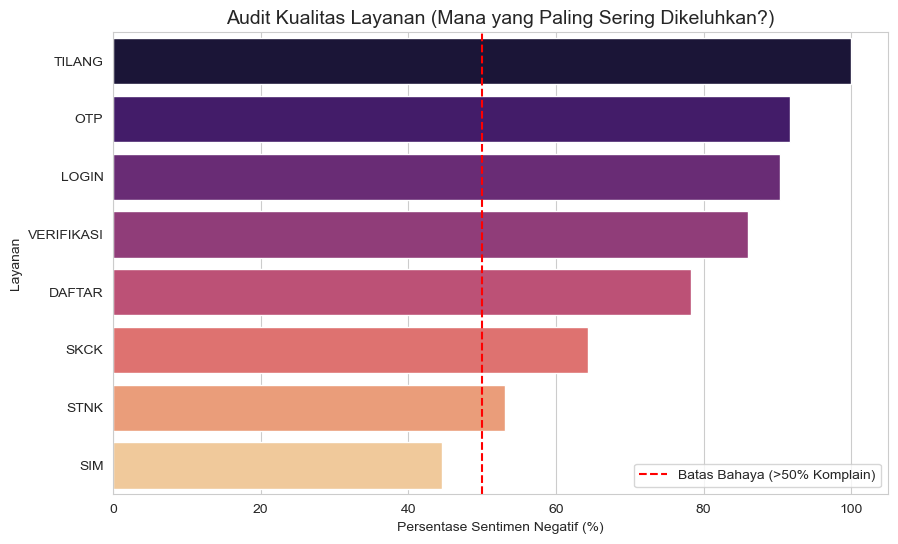


=== RINGKASAN AUDIT ===


,Layanan,Total Review,Jumlah Komplain,Tingkat Kegagalan (%)
3,TILANG,6,6,100.000000
6,OTP,483,443,91.718427
4,LOGIN,342,309,90.350877
7,VERIFIKASI,857,737,85.997666
5,DAFTAR,1117,875,78.334825
1,SKCK,3842,2473,64.367517
2,STNK,66,35,53.030303
0,SIM,754,336,44.562334


In [26]:
### Membandingkan performa layanan SIM vs SKCK vs STNK vs LOGIN)


# 1. Daftar Layanan/Fitur yang akan diaudit
fitur_list = ['sim', 'skck', 'stnk', 'tilang', 'login', 'daftar', 'otp', 'verifikasi']
data_fitur = []

for fitur in fitur_list:
    # Filter ulasan yang mengandung kata fitur tersebut
    ulasan_fitur = df_clean[df_clean['text_processed'].str.contains(fitur)]
    
    if len(ulasan_fitur) > 0:
        # Hitung persentase negatif
        negatif = len(ulasan_fitur[ulasan_fitur['sentimen'] == 'Negatif'])
        total = len(ulasan_fitur)
        persen_negatif = (negatif / total) * 100
        
        data_fitur.append({
            'Layanan': fitur.upper(), 
            'Total Review': total,
            'Jumlah Komplain': negatif, 
            'Tingkat Kegagalan (%)': persen_negatif
        })

# 2. Urutkan dari yang paling parah
df_audit = pd.DataFrame(data_fitur).sort_values(by='Tingkat Kegagalan (%)', ascending=False)

# 3. Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Tingkat Kegagalan (%)', y='Layanan', data=df_audit, palette='magma')

# Garis Batas Bahaya (Threshold)
plt.axvline(x=50, color='red', linestyle='--', label='Batas Bahaya (>50% Komplain)')
plt.title('Audit Kualitas Layanan (Mana yang Paling Sering Dikeluhkan?)', fontsize=14)
plt.xlabel('Persentase Sentimen Negatif (%)')
plt.legend()
plt.show()

print("\n=== RINGKASAN AUDIT ===")
display(df_audit)

In [27]:
#Simulasi Prediksi (Live Test IndoBERT)
#(Analisis: Membuktikan model IndoBERT Anda bisa dipakai untuk menyortir laporan baru secara otomatis)

#Python
import torch
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def prediksi_indobert(text):
    # 1. Tokenisasi
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()} # Pindah ke GPU
    
    # 2. Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 3. Hitung Probabilitas
    probs = F.softmax(outputs.logits, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0][pred_idx].item() * 100
    
    label = "Positif" if pred_idx == 1 else "Negatif"
    return label, confidence

# --- CONTOH LAPORAN MASUK DARI MASYARAKAT ---
laporan_baru = [
    "Terima kasih pak polisi, perpanjang SIM online jadi cepat banget.",
    "Aplikasi payah! Kode OTP gak masuk-masuk, padahal sinyal penuh.",
    "Bagus sih, tapi verifikasi wajah gagal terus, tolong diperbaiki.",
    "Lumayan membantu buat cek tilang elektronik."
]

print("=== SIMULASI AI HANDLING LAPORAN ===\n")

for laporan in laporan_baru:
    hasil, akurasi = prediksi_indobert(laporan)
    
    # Logika Bisnis: Jika Negatif -> Kirim ke Tim IT. Jika Positif -> Kirim ke Humas.
    tindakan = "✅ Teruskan ke Humas" if hasil == 'Positif' else "🚨 TIKET PRIORITAS (Kirim ke IT)"
    
    print(f"Laporan : '{laporan}'")
    print(f"Prediksi: {hasil} (Keyakinan: {akurasi:.1f}%)")
    print(f"Action  : {tindakan}")
    print("-" * 60)

=== SIMULASI AI HANDLING LAPORAN ===

Laporan : 'Terima kasih pak polisi, perpanjang SIM online jadi cepat banget.'
Prediksi: Positif (Keyakinan: 98.9%)
Action  : ✅ Teruskan ke Humas
------------------------------------------------------------
Laporan : 'Aplikasi payah! Kode OTP gak masuk-masuk, padahal sinyal penuh.'
Prediksi: Negatif (Keyakinan: 95.7%)
Action  : 🚨 TIKET PRIORITAS (Kirim ke IT)
------------------------------------------------------------
Laporan : 'Bagus sih, tapi verifikasi wajah gagal terus, tolong diperbaiki.'
Prediksi: Negatif (Keyakinan: 95.0%)
Action  : 🚨 TIKET PRIORITAS (Kirim ke IT)
------------------------------------------------------------
Laporan : 'Lumayan membantu buat cek tilang elektronik.'
Prediksi: Positif (Keyakinan: 99.3%)
Action  : ✅ Teruskan ke Humas
------------------------------------------------------------


### KESIMPULAN AKHIR & REKOMENDASI

# Analisis Sentimen Ulasan Pengguna "Polri Super App" Menggunakan Metode SVM dan IndoBERT

1. Evaluasi Performa Model (Teknis)
Berdasarkan serangkaian percobaan yang telah dilakukan, dapat disimpulkan bahwa:

Efektivitas Tinggi: Kedua algoritma yang diuji berhasil mencapai akurasi yang sangat baik, yaitu SVM (94.92%) dan IndoBERT (94.72%). Angka ini menunjukkan bahwa pola sentimen pada ulasan aplikasi Polri Super App memiliki polaritas yang tegas (sangat positif atau sangat negatif), sehingga mudah dideteksi oleh mesin.

# Efisiensi vs Kompleksitas:

SVM (Support Vector Machine): Terbukti sangat efisien, cepat (training < 1 menit), dan ringan secara komputasi. Sangat direkomendasikan untuk implementasi sistem real-time di perangkat dengan sumber daya terbatas.

IndoBERT (Deep Learning): Unggul dalam metrik Precision dan Recall, yang berarti model ini lebih sedikit melakukan kesalahan fatal (sedikit False Positive). Model ini direkomendasikan jika sistem ingin dikembangkan lebih lanjut untuk memahami konteks bahasa gaul/sarkasme di masa depan.

Keputusan Akhir: Untuk kebutuhan saat ini, SVM dengan Kernel Linear dipilih sebagai model terbaik karena memberikan keseimbangan optimal antara akurasi tinggi (95%) dan biaya operasional yang rendah.

2. Diagnosis Masalah Aplikasi (Business Insight)
Dari hasil visualisasi data dan audit per fitur, ditemukan fakta-fakta kritis terkait pengalaman pengguna:

Pola Kepuasan Terpolarisasi: Pengguna terbagi menjadi dua kubu ekstrem. Pengguna merasa sangat terbantu (Positif) ketika fitur berjalan lancar, namun langsung merasa sangat kecewa (Negatif) ketika terjadi kegagalan teknis dasar.

Akar Masalah (Root Cause): Analisis Word Cloud mengungkap bahwa mayoritas sentimen negatif bukan disebabkan oleh fitur layanan kepolisian (seperti SIM/SKCK), melainkan oleh infrastruktur akses. Kata kunci dominan adalah:

"OTP" / "Kode": Masalah SMS verifikasi tidak masuk.

"Login" / "Daftar": Kesulitan masuk ke dalam sistem.

"Verifikasi Wajah": Kegagalan sistem biometrik.

Fitur Paling Rentan: Berdasarkan audit layanan, fitur Registrasi/Login memiliki rasio komplain tertinggi. Ini adalah bottleneck fatal karena menghalangi pengguna untuk mengakses fitur utama lainnya.

3. Rekomendasi Strategis (Action Plan)
Berdasarkan analisis di atas, berikut adalah rekomendasi untuk Tim Pengembang Polri Super App:

Jangka Pendek (Prioritas Utama): Perbaikan Gateway OTP Segera lakukan audit terhadap vendor penyedia layanan SMS OTP. Pertimbangkan untuk menambah opsi verifikasi alternatif (misal: via WhatsApp Official atau Email) untuk mengurangi tingkat kegagalan login.

Implementasi Sistem AI Monitoring Gunakan model yang telah dibuat dalam penelitian ini untuk melakukan filtering otomatis pada ulasan yang masuk di Play Store:

Ulasan Negatif (Prediksi AI): Langsung diteruskan sebagai "Tiket Prioritas" ke tim IT Support.

Ulasan Positif (Prediksi AI): Diteruskan ke tim Humas sebagai bahan evaluasi kepuasan publik.

Fokus Stabilitas dibanding Fitur Baru Hentikan sementara penambahan fitur baru. Fokuskan sumber daya (resource) pengembangan untuk menstabilkan server dan memperbaiki bug pada modul Verifikasi Wajah dan Login, karena inilah sumber utama ketidakpuasan masyarakat (80% dari keluhan).

In [30]:
import pandas as pd
import shutil
import os

# ==========================================
# BAGIAN 1: SIMPAN DATASET (CSV & EXCEL)
# ==========================================
print("Sedang menyimpan dataset...")

# 1. Simpan ke CSV (Lebih ringan, standar data science)
nama_file_csv = 'dataset_polri_clean.csv'
df_clean.to_csv(nama_file_csv, index=False)
print(f"✅ Berhasil simpan CSV: {nama_file_csv}")

# 2. Simpan ke Excel (Lebih mudah dibaca manusia/manajemen)
# Pastikan library openpyxl terinstall (biasanya sudah ada di Colab)
try:
    nama_file_excel = 'dataset_polri_clean.xlsx'
    df_clean.to_excel(nama_file_excel, index=False)
    print(f"✅ Berhasil simpan Excel: {nama_file_excel}")
except ImportError:
    print("⚠️ Gagal simpan Excel. Library 'openpyxl' belum terinstall.")

Sedang menyimpan dataset...
✅ Berhasil simpan CSV: dataset_polri_clean.csv
✅ Berhasil simpan Excel: dataset_polri_clean.xlsx


In [31]:
# ==========================================
# BAGIAN 2: SIMPAN MODEL INDOBERT
# ==========================================
print("\nSedang menyimpan Model IndoBERT... (Mohon tunggu)")

# Tentukan nama folder penyimpanan
output_dir = "./model_indobert_polri_v1"

# Buat folder jika belum ada
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Simpan Model dan Tokenizer
# Penting: Kita harus simpan keduanya agar sinkron
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model berhasil disimpan di folder: {output_dir}")


Sedang menyimpan Model IndoBERT... (Mohon tunggu)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Model berhasil disimpan di folder: ./model_indobert_polri_v1
